In [1]:
import numpy as np
import xarray as xr
import os
import pandas as pd
import sys

sys.path.append(os.path.abspath(".."))
from utils.degree_day_equations import *
from utils.net_cdf_functions import *
from utils.processing_functions import *
# from utils.visualization_functions import *

# from visualization_functions import *
data_path = "../data/"

In [2]:
fly_models = {
    "Mexfly": {"UTT": 999, "LTT": 9.4, "dd_threshold": 754},
    "OFF": {"UTT": 999, "LTT": 8.375, "dd_threshold": 625},
    "Medfly": {"UTT": 999, "LTT": 12.44, "dd_threshold": 346},
    "Z. tau": {"UTT": 999, "LTT": 9.22, "dd_threshold": 459.28},
}

In [3]:
raw_data = pd.read_csv("filtered_detections.csv")
raw_data = raw_data[raw_data["Stage"] == "Adult"]
# Set raw_data "Date" as dates
raw_data["Date"] = pd.to_datetime(raw_data["Date"])
raw_data["DD_from_first_detection"] = np.nan
raw_data["gen_from_first_detection"] = np.nan
raw_data["DD_from_last_detection"] = np.nan
raw_data["gen_from_last_detection"] = np.nan
raw_data["order_in_cluster"] = np.nan

In [4]:
clusters = raw_data["Cluster"].unique()
clusters

array(['21CA-SAN01.01', '21CA-SBE01.01', '22CA-DIE01.01', '22CA-LOS01.01',
       '22CA-ORA01.01', '23CA-ANG01.01', '23CA-BER01.01', '23CA-CLA01.01',
       '23CA-CON01.01', '23CA-SAC01.01', '24CA-ALA01.01', '24CA-ANG02.01',
       '24CA-VEN01.01', '25CA-ORA01.01'], dtype=object)

In [7]:
for cluster_ID in clusters:
    cluster_data = raw_data[raw_data["Cluster"] == cluster_ID].sort_values(by="Date")
    try:
        target_species = cluster_data["Common Name"].values[0]
    except KeyError:
        target_species = cluster_data["Common Name"].values[1]

    try:
        fly_params = fly_models[target_species]
    except KeyError:
        print("skipping " + target_species)
        continue
    is_first = 1
    previous_detection_date = None
    cluster_order = 1
    print("working on" + cluster_ID + target_species)
    #######
    # Weather Data SETUP#
    base_url = "https://thredds.climate.ncsu.edu/thredds/ncss/grid/prism/daily/combo"
    cluster_bbox = (
        cluster_data["LON"].min(),
        cluster_data["LON"].max(),
        cluster_data["LAT"].min(),
        cluster_data["LAT"].max(),
    )
    cluster_start_date = cluster_data["Date"].min()
    cluster_end_date = cluster_data["Date"].max() + pd.Timedelta(days=200)
    n_days = (cluster_end_date - cluster_start_date).days
    cluster_start_date_str = cluster_start_date.strftime("%Y-%m-%d")
    if cluster_end_date > pd.Timestamp.now() - pd.Timedelta(days=2):
        print(
            f"Skipping cluster {cluster_ID} as the end date is too close to the current date."
        )
        continue
    try:
        cluster_raw_PRISM = fetch_ncss_data(
            start_date=cluster_start_date_str, n_days=n_days, bbox=cluster_bbox
        )
    except TypeError:
        print("type")
        print(base_url)
        print(cluster_start_date_str)
        print(n_days)
        print(cluster_bbox)
    cluster_DD_data = da_calculate_degree_days(
        fly_params["LTT"], fly_params["UTT"], cluster_raw_PRISM
    )
    #############
    # individual trap calculations

    for index, row in cluster_data.iterrows():
        print("*****************")

        trap_id = row["Detection Code"]
        trap_lat = row["LAT"]
        trap_lon = row["LON"]
        trap_date = row["Date"]
        raw_data.at[index, "order_in_cluster"] = cluster_order
        cluster_order += 1
        # Calculate degree days for the trap location
        trap_dd = cluster_DD_data.sel(
            latitude=trap_lat, longitude=trap_lon, method="nearest"
        )

        # Calculate cumulative degree days up to the trap date
        cumulative_dd = trap_dd.sel(t=slice(cluster_start_date, trap_date)).sum().item()
        print(
            "cum dd at trap "
            + str(trap_lat)
            + " "
            + str(trap_lon)
            + " "
            + str(cumulative_dd)
        )
        # Calculate cumulative degree days from the most recent detection date to the trap date
        if previous_detection_date is not None and previous_detection_date != trap_date:
            print("trapdate:" + str(trap_date))
            print("prevdate" + str(previous_detection_date))
            cumulative_dd_from_recent = (
                trap_dd.sel(t=slice(previous_detection_date, trap_date)).sum().item()
            )
            print(cumulative_dd_from_recent)
        elif previous_detection_date == trap_date:
            cumulative_dd_from_recent = 0
        else:
            cumulative_dd_from_recent = None

        # Update the DataFrame with the results

        if cumulative_dd_from_recent is not None:
            raw_data.at[index, "DD_from_first_detection"] = cumulative_dd
            raw_data.at[index, "gen_from_first_detection"] = round(
                cumulative_dd / fly_params["dd_threshold"], 2
            )
            raw_data.at[index, "gen_from_last_detection"] = round(
                cumulative_dd_from_recent / fly_params["dd_threshold"], 2
            )
            raw_data.at[index, "DD_from_last_detection"] = round(
                cumulative_dd_from_recent, 2
            )
        else:
            raw_data.at[index, "DD_from_first_detection"] = 0
            raw_data.at[index, "gen_from_first_detection"] = 0
            raw_data.at[index, "gen_from_last_detection"] = np.nan
            raw_data.at[index, "DD_from_last_detection"] = np.nan
        # Update the previous detection date
        previous_detection_date = trap_date

working on21CA-SAN01.01OFF
*****************
cum dd at trap 37.29 -121.82 13.334599494934082
*****************
cum dd at trap 37.29 -121.83 77.89064693450928
trapdate:2021-09-20 00:00:00
prevdate2021-09-14 00:00:00
77.89064693450928
*****************
cum dd at trap 37.3 -121.84 77.89064693450928
*****************
cum dd at trap 37.3 -121.85 107.51389598846436
trapdate:2021-09-22 00:00:00
prevdate2021-09-20 00:00:00
39.891448974609375
*****************
cum dd at trap 37.3 -121.84 120.86649560928345
trapdate:2021-09-23 00:00:00
prevdate2021-09-22 00:00:00
29.5061993598938
*****************
cum dd at trap 37.29 -121.84 134.6470947265625
trapdate:2021-09-24 00:00:00
prevdate2021-09-23 00:00:00
27.133198738098145
*****************
cum dd at trap 37.28 -121.88 186.71599435806274
trapdate:2021-09-29 00:00:00
prevdate2021-09-24 00:00:00
65.47929763793945
working on21CA-SBE01.01Medfly
*****************
cum dd at trap 34.15 -117.66 3.2991158762300827
*****************
cum dd at trap 34.12 -117.6

KeyboardInterrupt: 

In [ ]:
raw_data

,Entry Number,Detection Code,Date,Month,FY,City,County,State,LAT,LON,...,Ratio Sterile:Wild,1 Fly Life Cycle,2 Fly Life Cycle,3 Fly Life Cycle,Notes,DD_from_first_detection,gen_from_first_detection,DD_from_last_detection,gen_from_last_detection,order_in_cluster
6,743,x7,2021-09-29,NaN,2021,San Jose,Santa Clara,CA,37.28,-121.88,...,NaN,NaN,NaN,NaN,NaN,186.715994,0.30,65.48,0.10,7.0
0,749,x1,2021-09-24,NaN,2021,San Jose,Santa Clara,CA,37.29,-121.84,...,NaN,NaN,NaN,NaN,NaN,134.647095,0.22,27.13,0.04,6.0
1,748,x2,2021-09-23,NaN,2021,San Jose,Santa Clara,CA,37.30,-121.84,...,NaN,NaN,NaN,NaN,NaN,120.866496,0.19,29.51,0.05,5.0
2,747,x3,2021-09-22,NaN,2021,San Jose,Santa Clara,CA,37.30,-121.85,...,NaN,NaN,NaN,NaN,NaN,107.513896,0.17,39.89,0.06,4.0
4,745,x5,2021-09-20,NaN,2021,San Jose,Santa Clara,CA,37.30,-121.84,...,NaN,NaN,NaN,NaN,NaN,77.890647,0.12,0.00,0.00,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,6,AH0P06298535,2024-10-28,NaN,2025,Santa Ana,Orange,CA,33.75,-117.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
744,5,AH0P06298534,2024-10-25,NaN,2025,Garden Grove,Orange,CA,33.75,-117.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745,4,AH0P06298533,2024-10-25,NaN,2025,Garden Grove,Orange,CA,33.75,-117.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,3,AH0P06298532,2024-10-24,NaN,2025,Santa Ana,Orange,CA,33.75,-117.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
raw_data = raw_data.sort_values(
    by=["Cluster", "order_in_cluster"], ascending=[True, False]
)

In [45]:
raw_data.to_csv("ff_detections_number_generations_processed_2_7.csv")

In [12]:
cluster_data

,Entry Number,Detection Code,Date,Month,FY,City,County,State,LAT,LON,...,Eradication Code,Quarantine,Cluster,Trap,Location,Ratio Sterile:Wild,1 Fly Life Cycle,2 Fly Life Cycle,3 Fly Life Cycle,Notes
5,744,x6,2021-09-14,NaN,2021,San Jose,Santa Clara,CA,37.29,-121.82,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
3,746,x4,2021-09-20,NaN,2021,San Jose,Santa Clara,CA,37.29,-121.83,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
4,745,x5,2021-09-20,NaN,2021,San Jose,Santa Clara,CA,37.30,-121.84,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
2,747,x3,2021-09-22,NaN,2021,San Jose,Santa Clara,CA,37.30,-121.85,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
1,748,x2,2021-09-23,NaN,2021,San Jose,Santa Clara,CA,37.30,-121.84,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
0,749,x1,2021-09-24,NaN,2021,San Jose,Santa Clara,CA,37.29,-121.84,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
6,743,x7,2021-09-29,NaN,2021,San Jose,Santa Clara,CA,37.28,-121.88,...,NaN,21CA-SAN01.01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
cluster_DD_data

<xarray.DataArray 'degree_days' (t: 216, latitude: 1, longitude: 2)> Size: 3kB
array([[[13.19799995, 13.33459949]],

       [[12.94234991, 12.78604889]],

       [[11.1854496 , 11.0753994 ]],

       [[ 9.92454958,  9.94964981]],

       [[10.01889992, 10.17394972]],

       [[10.28979969, 10.3027997 ]],

       [[10.3316493 , 10.26819992]],

       [[13.66909933, 13.46964931]],

       [[16.24394989, 16.15359974]],

       [[13.43294954, 13.35259962]],

...

       [[14.32304955, 14.33699894]],

       [[10.65664959, 10.92219973]],

       [[ 7.51240541,  7.57710028]],

       [[ 6.8576498 ,  6.7772994 ]],

       [[ 2.7649871 ,  2.59060233]],

       [[ 3.03172136,  2.88560681]],

       [[ 3.29005782,  3.32697298]],

       [[ 4.68714952,  4.49389982]],

       [[ 7.26474953,  7.18930006]],

       [[ 4.59928533,  4.54240869]]])
Coordinates:
  * t          (t) datetime64[ns] 2kB 2021-09-14 2021-09-15 ... 2022-04-17
  * latitude   (latitude) float64 8B 37.29
  * longitude  (longitude) float64 16B -121.9 -121.8

In [ ]:
cluster_raw_PRISM

In [16]:
cluster_data

,Entry Number,Detection Code,Date,Month,FY,City,County,State,LAT,LON,...,Eradication Code,Quarantine,Cluster,Trap,Location,Ratio Sterile:Wild,1 Fly Life Cycle,2 Fly Life Cycle,3 Fly Life Cycle,Notes
0,749,NaN,9/24/21,NaN,2021,San Jose,Santa Clara,CA,37.29,-121.84,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
1,748,NaN,9/23/21,NaN,2021,San Jose,Santa Clara,CA,37.30,-121.84,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
2,747,NaN,9/22/21,NaN,2021,San Jose,Santa Clara,CA,37.30,-121.85,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
3,746,NaN,9/20/21,NaN,2021,San Jose,Santa Clara,CA,37.29,-121.83,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
4,745,NaN,9/20/21,NaN,2021,San Jose,Santa Clara,CA,37.30,-121.84,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
5,744,NaN,9/14/21,NaN,2021,San Jose,Santa Clara,CA,37.29,-121.82,...,NaN,21CA-SAN01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN
6,743,NaN,9/29/21,NaN,2021,San Jose,Santa Clara,CA,37.28,-121.88,...,NaN,21CA-SAN01.01.01,21CA-SAN01.01,Jackson,NaN,NaN,NaN,NaN,NaN,NaN


     latitude  longitude                     geometry
0       37.29    -121.84  POINT (-121.84000 37.29000)
1       37.30    -121.84  POINT (-121.84000 37.30000)
2       37.30    -121.85  POINT (-121.85000 37.30000)
3       37.29    -121.83  POINT (-121.83000 37.29000)
4       37.30    -121.84  POINT (-121.84000 37.30000)
..        ...        ...                          ...
743     33.75    -117.92  POINT (-117.92000 33.75000)
744     33.75    -117.92  POINT (-117.92000 33.75000)
745     33.75    -117.95  POINT (-117.95000 33.75000)
746     33.75    -117.92  POINT (-117.92000 33.75000)
747     33.75    -117.95  POINT (-117.95000 33.75000)

[748 rows x 3 columns]


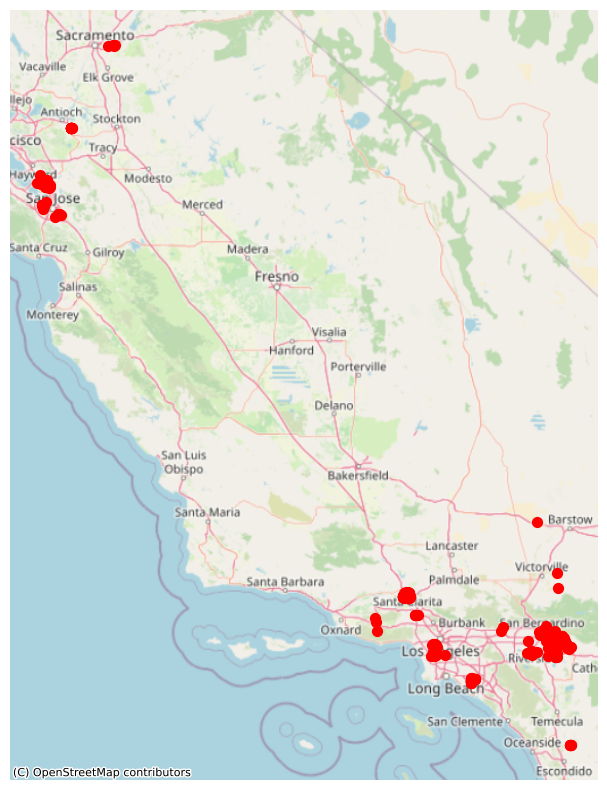

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx


# Select LAT and LON from raw_data
data = raw_data[["LAT", "LON"]].rename(columns={"LAT": "latitude", "LON": "longitude"})

# Create a DataFrame
df = pd.DataFrame(data)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Set the coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Display the GeoDataFrame
print(gdf)

# Plot Data on OSM Basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame
gdf.plot(ax=ax, color="red", markersize=50)

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set axis off
ax.set_axis_off()

plt.show()

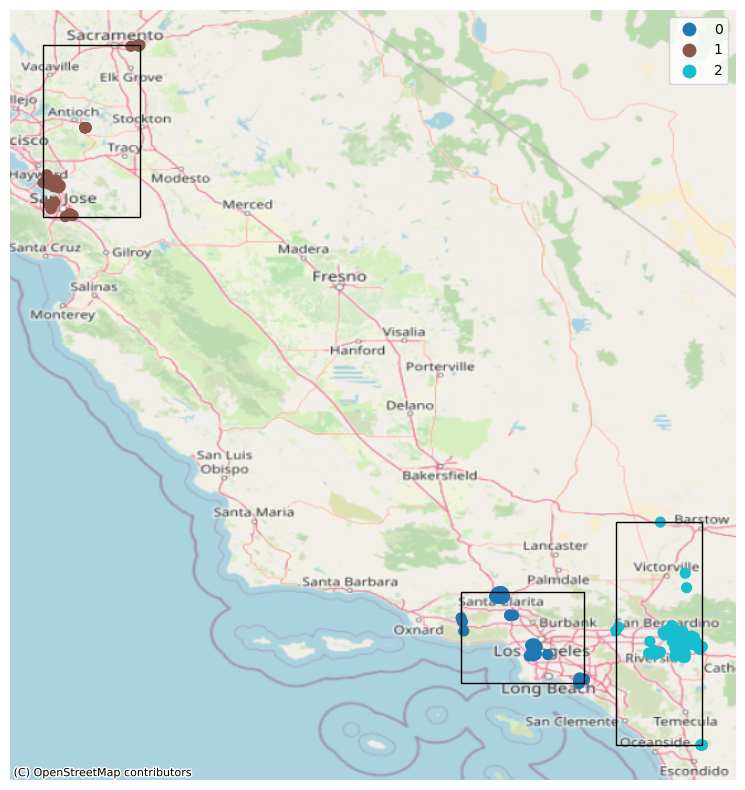

In [27]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import KMeans
from shapely.geometry import box

# Sample raw data


# Select LAT and LON from raw_data
data = raw_data[["LAT", "LON"]].rename(columns={"LAT": "latitude", "LON": "longitude"})

# Create a DataFrame
df = pd.DataFrame(data)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Set the coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Cluster the points into 5 groups
kmeans = KMeans(n_clusters=3)
gdf["cluster"] = kmeans.fit_predict(gdf[["longitude", "latitude"]])

# Calculate bounding boxes for each cluster
bounding_boxes = []
bbox_coords = []
for cluster in gdf["cluster"].unique():
    cluster_points = gdf[gdf["cluster"] == cluster]
    minx, miny, maxx, maxy = cluster_points.total_bounds
    bounding_boxes.append(box(minx, miny, maxx, maxy))
    bbox_coords.append([minx, maxx, miny, maxy])
# Plot Data on OSM Basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame
gdf.plot(ax=ax, column="cluster", categorical=True, legend=True, markersize=50)

# Plot bounding boxes
for bbox in bounding_boxes:
    gpd.GeoSeries([bbox]).plot(ax=ax, edgecolor="black", facecolor="none")

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set axis off
ax.set_axis_off()

plt.show()

c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\sklearn\ba

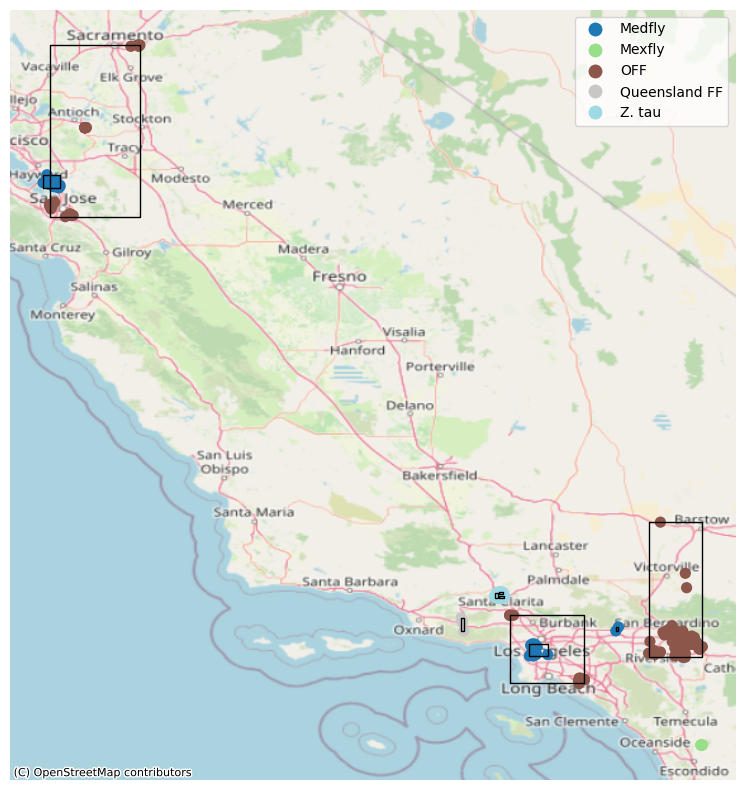

In [36]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import KMeans
from shapely.geometry import box


# Select LAT, LON, and Common Name from raw_data
data = raw_data[["LAT", "LON", "Common Name"]].rename(
    columns={"LAT": "latitude", "LON": "longitude"}
)

# Create a DataFrame
df = pd.DataFrame(data)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Set the coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Initialize cluster column
gdf["cluster"] = -1

# Cluster the points by species
cluster_id = 0
for common_name in gdf["Common Name"].unique():
    species_points = gdf[gdf["Common Name"] == common_name]
    n_clusters = min(3, len(species_points) - 2)
    if len(species_points) < 5:
        n_clusters = 1
    kmeans = KMeans(n_clusters=n_clusters)
    species_points["cluster"] = (
        kmeans.fit_predict(species_points[["longitude", "latitude"]]) + cluster_id
    )
    gdf.loc[species_points.index, "cluster"] = species_points["cluster"]
    cluster_id += len(species_points["cluster"].unique())

# Calculate bounding boxes for each cluster
bounding_boxes = []
for cluster in gdf["cluster"].unique():
    cluster_points = gdf[gdf["cluster"] == cluster]
    minx, miny, maxx, maxy = cluster_points.total_bounds
    bounding_boxes.append(box(minx, miny, maxx, maxy))

# Plot Data on OSM Basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with clusters and color by species
gdf.plot(
    ax=ax,
    column="Common Name",
    categorical=True,
    legend=True,
    markersize=50,
    cmap="tab20",
)

# Plot bounding boxes and add text annotations for Common Name
for cluster in gdf["cluster"].unique():
    cluster_points = gdf[gdf["cluster"] == cluster]
    minx, miny, maxx, maxy = cluster_points.total_bounds
    bbox = box(minx, miny, maxx, maxy)
    gpd.GeoSeries([bbox]).plot(ax=ax, edgecolor="black", facecolor="none")

    # Calculate the center of the bounding box for annotation
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    # Get the common name for the cluster
    common_name = cluster_points["Common Name"].iloc[0]

    # Add text annotation
# ax.text(center_x, center_y, common_name, horizontalalignment='center', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set axis off
ax.set_axis_off()

plt.show()

In [18]:
gdf

,latitude,longitude,Common Name,geometry,cluster
0,34.05,-118.25,A,POINT (-118.25000 34.05000),0
1,36.16,-115.15,B,POINT (-115.15000 36.16000),1
2,40.71,-74.01,C,POINT (-74.01000 40.71000),2
3,34.05,-118.25,A,POINT (-118.25000 34.05000),0
4,36.16,-115.15,B,POINT (-115.15000 36.16000),1
5,40.71,-74.01,C,POINT (-74.01000 40.71000),2


In [ ]:
import os

# Load all the downloaded NetCDF files into a single xarray dataset
output_dir = "data/daymet"
nc_files = [
    os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(".nc")
]
combined_data = xr.open_mfdataset(nc_files, combine="by_coords")

# Move lat and lon from data variables to coordinates
combined_data = combined_data.set_coords(["lat", "lon"])
combined_data = combined_data.drop_vars("lambert_conformal_conic")
combined_data["time"] = combined_data["time"].compute()
combined_data["lat"] = combined_data["lat"].compute()
combined_data["lon"] = combined_data["lon"].compute()

# Write CRS and reproject
combined_data = combined_data.rio.write_crs(
    "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
)
combined_rep = combined_data.rio.reproject("EPSG:4326")

print(combined_rep)

ValueError: conflicting sizes for dimension 'y': length 68 on the data but length 79 on coordinate 'lon'

for each species